In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
regions = ['warszawski', 'krakowski', 'poznański', 'wrocławski', 'gdański',
           'łódzki', 'katowicki', 'lubelski', 'bydgoski', 'szczecinski']

years = [2020, 2021, 2022, 2023, 2024]

crime_types = ['kradzież', 'rozbój', 'włamanie', 'oszustwo', 'pobicie',
               'uszkodzenie mienia', 'kradzież samochodu', 'wymuszenie']

population_data = {
    'warszawski': 3500000,
    'krakowski': 1800000,
    'poznański': 1400000,
    'wrocławski': 1300000,
    'gdański': 1100000,
    'łódzki': 1050000,
    'katowicki': 2200000,
    'lubelski': 800000,
    'bydgoski': 950000,
    'szczecinski': 700000
}

np.random.seed(42)

powiaty = np.random.choice(regions, size=200)

data = {
    'rok': np.random.choice(years, size=200),
    'powiat': powiaty,
    'rodzaj_przestepstwa': np.random.choice(crime_types, size=200),
    'liczba': np.random.randint(10, 1500, size=200),
    'ludność': [population_data[p] for p in powiaty]
}

df = pd.DataFrame(data)

df = df.sort_values(['rok', 'powiat', 'rodzaj_przestepstwa']).reset_index(drop=True)

print(df.head(20))
print(f"\nWymiary DataFrame: {df.shape}")
print(f"\nLiczba unikalnych wartości:")
print(f"  - Lata: {df['rok'].nunique()}")
print(f"  - Powiaty: {df['powiat'].nunique()}")
print(f"  - Rodzaje przestępstw: {df['rodzaj_przestepstwa'].nunique()}")
print(df.describe())

     rok     powiat rodzaj_przestepstwa  liczba  ludność
0   2020   bydgoski            kradzież     763   950000
1   2020   bydgoski            oszustwo    1381   950000
2   2020   bydgoski             pobicie     885   950000
3   2020   bydgoski             pobicie    1406   950000
4   2020   bydgoski  uszkodzenie mienia    1334   950000
5   2020   bydgoski  uszkodzenie mienia     698   950000
6   2020    gdański  kradzież samochodu     509  1100000
7   2020    gdański  kradzież samochodu     163  1100000
8   2020    gdański              rozbój      48  1100000
9   2020    gdański              rozbój    1234  1100000
10  2020    gdański          wymuszenie     773  1100000
11  2020    gdański          wymuszenie     741  1100000
12  2020  katowicki            kradzież     718  2200000
13  2020  katowicki            oszustwo    1038  2200000
14  2020  katowicki            oszustwo     394  2200000
15  2020  katowicki              rozbój    1087  2200000
16  2020  krakowski            

In [9]:
max_crime_region = df.groupby('powiat').agg({
    'liczba': 'sum',
    'ludność': 'first'
}).reset_index()

max_crime_region['liczba_przestepstw_na_100k'] = (max_crime_region['liczba'] / max_crime_region['ludność']) * 100000

print(max_crime_region.sort_values(by='liczba_przestepstw_na_100k', ascending=False))

        powiat  liczba  ludność  liczba_przestepstw_na_100k
6  szczecinski   19134   700000                 2733.428571
4     lubelski   15493   800000                 1936.625000
0     bydgoski   18285   950000                 1924.736842
1      gdański   14817  1100000                 1347.000000
2    katowicki   27200  2200000                 1236.363636
8   wrocławski   13930  1300000                 1071.538462
5    poznański   14935  1400000                 1066.785714
9       łódzki   10107  1050000                  962.571429
3    krakowski   12335  1800000                  685.277778
7   warszawski   17123  3500000                  489.228571


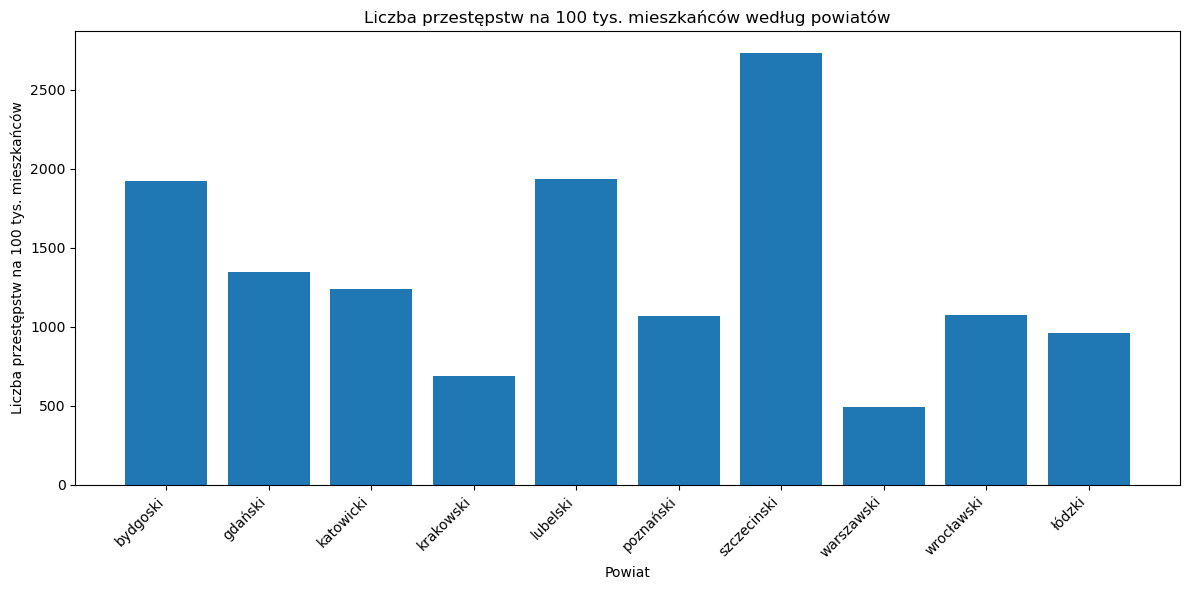

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(max_crime_region['powiat'], max_crime_region['liczba_przestepstw_na_100k'])
plt.xlabel('Powiat')
plt.ylabel('Liczba przestępstw na 100 tys. mieszkańców')
plt.title('Liczba przestępstw na 100 tys. mieszkańców według powiatów')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

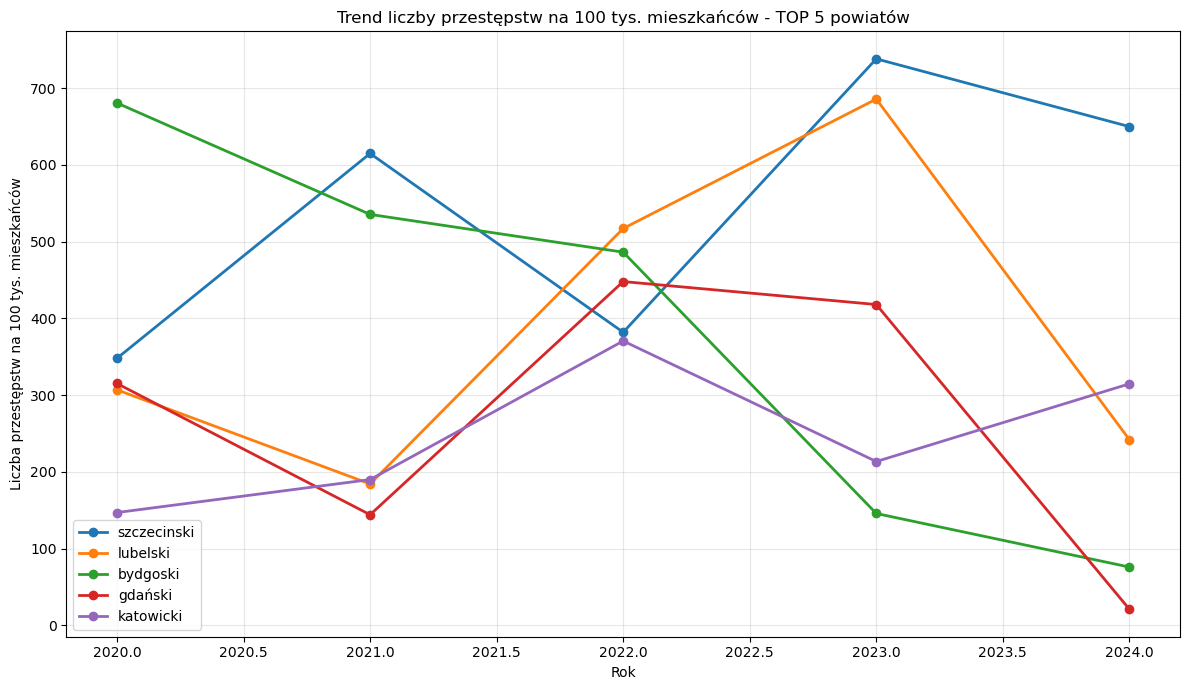

In [11]:
crime_trend = df.groupby(['rok', 'powiat']).agg({
    'liczba': 'sum',
    'ludność': 'first'
}).reset_index()

crime_trend['liczba_na_100k'] = (crime_trend['liczba'] / crime_trend['ludność']) * 100000

top5_regions = crime_trend.groupby('powiat')['liczba_na_100k'].mean().nlargest(5).index

crime_trend_top5 = crime_trend[crime_trend['powiat'].isin(top5_regions)]

plt.figure(figsize=(12, 7))

for region in top5_regions:
    region_data = crime_trend_top5[crime_trend_top5['powiat'] == region]
    plt.plot(region_data['rok'], region_data['liczba_na_100k'], marker='o', label=region, linewidth=2)

plt.xlabel('Rok')
plt.ylabel('Liczba przestępstw na 100 tys. mieszkańców')
plt.title('Trend liczby przestępstw na 100 tys. mieszkańców - TOP 5 powiatów')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()